In [80]:
# Imports
import os
import numpy as np
from matplotlib import pyplot as plt
import cv2
from PIL import Image as img
import math
from sklearn.cluster import KMeans
from scipy import stats
from scipy.stats import linregress



In [81]:

BRYGGE_SEKVENS = "./bilder/brygge_sekvens"
BRO_SEKVENS = "./bilder/bro_sekvens"
LAGRA_BILDER = ".bilder/lagra_bilete"
BLANDA_SEKVENS = "./bilder/blanda_sekvens"
RESULT_FOLDER = BRYGGE_SEKVENS

K = np.loadtxt(f"{RESULT_FOLDER}/left/K_matrix.txt")
R = np.loadtxt(f"{RESULT_FOLDER}/left/R_matrix.txt")
T = np.loadtxt(f"{RESULT_FOLDER}/left/T_matrix.txt")

plt.ion()

# Under åpner vi ti = n'te bildet
left_images_filenames = list(filter(lambda fn: fn.split(".")[-1]=="png", os.listdir(f"{RESULT_FOLDER}/left")))
timestamps = list(map(lambda fn: fn.split(".")[0], left_images_filenames))
ti = 0
timestamp = timestamps[ti]
left = cv2.imread(f"{RESULT_FOLDER}/left/{timestamp}.png")
right = cv2.imread(f"{RESULT_FOLDER}/right/{timestamp}.png")
disp = np.array(cv2.imread(f"{RESULT_FOLDER}/disp_zed/{timestamp}.png", cv2.IMREAD_ANYDEPTH) / 256.0, dtype=np.float32)

print("Første:" ,timestamps[0], " Nærme: ", timestamps[len(timestamps)-1])

def fetch_image(main_as_well=False, RES_FOLDER=RESULT_FOLDER, time=timestamp):

    plt.ion()
    new_main_image = cv2.imread(f"{RES_FOLDER}/left/{time}.png")
    new_main_image = cv2.cvtColor(new_main_image, cv2.COLOR_BGR2RGB)
    new_disparity_image = np.array(cv2.imread(f"{RES_FOLDER}/disp_zed/{time}.png", cv2.IMREAD_ANYDEPTH) / 256.0, dtype=np.float32)
    if(main_as_well):
        return new_disparity_image, new_main_image
    return new_disparity_image

def display_disp_image(to_be_displayed, title="Image", d_type="turbo"):
    plt.figure(figsize=(10, 6))
    plt.imshow(to_be_displayed, cmap=d_type)
    plt.title(title)
    plt.show()

def display_columns_on_image(input_image, col_indices=[500]):
    to_be_displayed = input_image.copy()
    colours = [(255,0,0), (0,255,0), (0,0,255)]
    height = to_be_displayed.shape[0]
    width = to_be_displayed.shape[1]

    for index, col_idx in enumerate(col_indices):
        colour = colours[index%3]

        to_be_displayed = cv2.line(to_be_displayed, (col_indices[index],0), (col_indices[index], height), colour, 3)
        #original_image = cv2.line(original_image, dimStart, dimSlutt, colour, 1)


    display_disp_image(to_be_displayed)


# Timestamps
# Første: 1689072599961543541  Nærme:  1689072633388130541 Bru:  1689068851836122093 Båt: 1689068854381001093
Første= 1689072599961543541  
Nærme=  1689072633388130541
Bru =  1689068851836122093
Båt =  1689068854381001093

# Fra blanda
Kajakk1 = 1689068879500907093
KajakkOgBåt = 1689068879500907093
KajakkBåtTett = 1689068866505573093
BåtBak = 1689068856993399093
BåtFram = 1689068871596675093
BaderingMann = 1689072623607882541
Badering = 1689072630042776541
BaderingMannMidten = 1689072625349756541

 

# Fetch a new current working image and respective disparity
# Dette er disp_første og venstre_første
#current_working_disparity, current_working_image = fetch_image(True)

# Dette er disp_nærme_brygga og nærme_brygga
current_working_disparity, current_working_image = fetch_image(True, RES_FOLDER=BRYGGE_SEKVENS ,time=Første)
første_disparity, første_image = fetch_image(True, RES_FOLDER=BRYGGE_SEKVENS ,time=Første)
nærme_disparity, nærme_image = fetch_image(True, RES_FOLDER=BRYGGE_SEKVENS, time=Nærme)
bru_disparity, bru_image = fetch_image(True, RES_FOLDER=BRO_SEKVENS, time=Bru)
båt_disparity, båt_image = fetch_image(True, RES_FOLDER=BRO_SEKVENS, time=Båt)

kajakk_første_disparity, kajakk_første_image = fetch_image(True, RES_FOLDER=BLANDA_SEKVENS ,time=Kajakk1)
kajakk_båt_disparity, kajakk_båt_image = fetch_image(True, RES_FOLDER=BLANDA_SEKVENS ,time=KajakkOgBåt)
kajakk_tett_disparity, kajakk_tett_image = fetch_image(True, RES_FOLDER=BLANDA_SEKVENS ,time=KajakkBåtTett)
båt_bak_disparity, båt_bak_image = fetch_image(True, RES_FOLDER=BLANDA_SEKVENS ,time=BåtBak)
båt_fram_disparity, båt_fram_image = fetch_image(True, RES_FOLDER=BLANDA_SEKVENS ,time=BåtFram)
badering_første_disparity, badering_første_image = fetch_image(True, RES_FOLDER=BLANDA_SEKVENS ,time=Badering)
badering_mann_disparity, badering_mann_image = fetch_image(True, RES_FOLDER=BLANDA_SEKVENS ,time=BaderingMann)
badering_midten_disparity, badering_midten_image = fetch_image(True, RES_FOLDER=BLANDA_SEKVENS ,time=BaderingMannMidten)

standard_fig_size = (10, 6)


Første: 1689072633388130541  Nærme:  1689072600363349541


In [82]:

def interpolate_column(column):
    # Indices of valid and invalid elements
    # Adds the indices of values that are valid meaning real numbers to valid_indices and invalid indices meaning inf, -inf and NaN to 
    valid_mask = np.isfinite(column)
    valid_indices = np.where(valid_mask)[0]
    invalid_indices = np.where(~valid_mask)[0]

    # Check if we have enough data for interpolation
    if len(valid_indices) == 0:
        # No valid data in this column
        return column
    elif len(invalid_indices) == 0:
        # No need for interpolation
        return column

    # Interpolate invalid data points
    valid_data = column[valid_mask]
    column[~valid_mask] = np.interp(invalid_indices, valid_indices, valid_data)
    return column

def interpolate_each_column(dI):
    # Applying the interpolation to each column
    height, width = dI.shape
    for x in range(width):
        dI[:, x] = interpolate_column(dI[:, x])

import matplotlib.colors as mcolors

def generate_dark_colors(n):
    # Define the saturation and value for dark colors
    saturation = 1.0  # full saturation for vivid colors
    value = 0.6  # dark enough to ensure good contrast on a white background
    
    # Generate colors
    colors = []
    for i in range(n):
        hue = i / n  # Evenly space hues around the color wheel
        rgb = mcolors.hsv_to_rgb((hue, saturation, value))
        colors.append(rgb)
    
    return colors

def disparity_graphing(disp_map, col_indices=[500], display=False, invert=False):
    
    colours = ['red', 'green', 'blue']

    plt.figure(figsize=standard_fig_size)
    # Extract and plot each column


    for i, col in enumerate(col_indices):
            if(col > disp_map.shape[1]):
                col_indices.pop(i+1)

    for index, col_idx in enumerate(col_indices):
        colour = colours[index%3]
        col_data = disp_map[:, col_idx]
        y_values = range(len(col_data))
        plt.plot(col_data, y_values, label=f'Column {index + 1} (Index {col_idx})', color=colour)


    title="Disparity profiles along Column(s) " + str(col_indices)

    # Invert y-axis to match image orientation
    if(invert):
        plt.gca().invert_yaxis()

    # Add labels and legend
    plt.xlabel('Disparity Value')
    plt.ylabel('V-value (rows)')
    plt.title(title)
    plt.legend()

    # Show the plot
    if(display):
        plt.show()

def display_columns_on_image(original_image, col_indices=[500]):
    colours = [(255,0,0), (0,255,0), (0,0,255)]
    height = original_image.shape[0]
    width = original_image.shape[1]

    og_image = original_image.copy()

    for i, col in enumerate(col_indices):
            if(col > og_image.shape[1]):
                print("Cols popped")
                col_indices.pop(i+1)

    title="Columns on original image"


    for index, col_idx in enumerate(col_indices):
        colour = colours[index%3]

        og_image = cv2.line(og_image, (col_indices[index],0), (col_indices[index], height), colour, 3)


    display_disp_image(og_image)


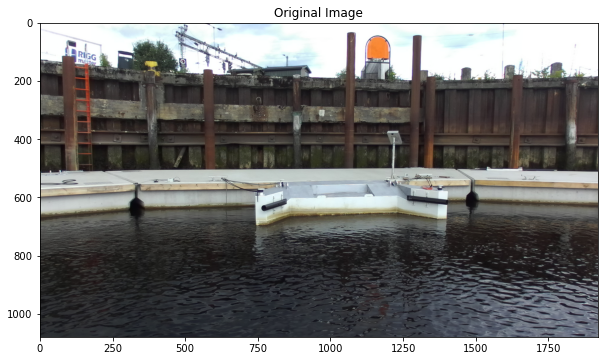

In [83]:
# Endre/change/velg
# Velg disparity bilde her!
#-------------------------------------------
#current_working_disparity, current_working_image 
#første_disparity, første_image 
#nærme_disparity, nærme_image 
#bru_disparity, bru_image 
#båt_disparity, båt_image
#
#dI = bru_disparity
#original_image = bru_image

#dI = båt_disparity
#original_image = båt_image

#dI = første_disparity
#original_image = første_image

dI = nærme_disparity
original_image = nærme_image

#dI = kajakk_første_disparity
#original_image = kajakk_første_image

#dI = kajakk_båt_disparity
#original_image = kajakk_båt_image

#dI = kajakk_tett_disparity
#original_image = kajakk_tett_image

#dI = båt_bak_disparity
#original_image = båt_bak_image

#dI = båt_fram_disparity
#original_image = båt_fram_image

#dI = badering_første_disparity
#original_image = badering_første_image

#dI = badering_mann_disparity
#original_image = badering_mann_image

#dI = badering_midten_disparity
#original_image = badering_midten_image

to_be_displayed = original_image

current_disparity_data = dI.copy()
interpolate_each_column(current_disparity_data)
display_disp_image(original_image, "Original Image")
#display_disp_image(current_disparity_data, "Interpolated Disparity Image")

In [84]:
display_columns_on_image

<function __main__.display_columns_on_image(original_image, col_indices=[500])>

Nærme


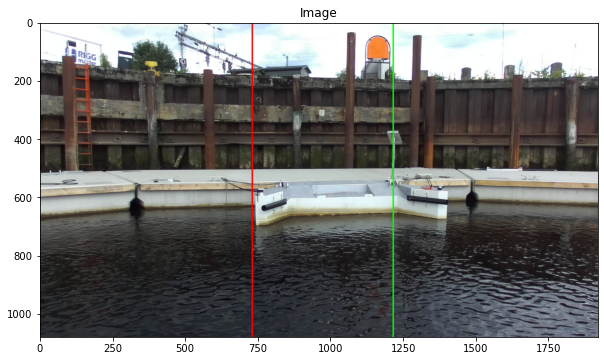

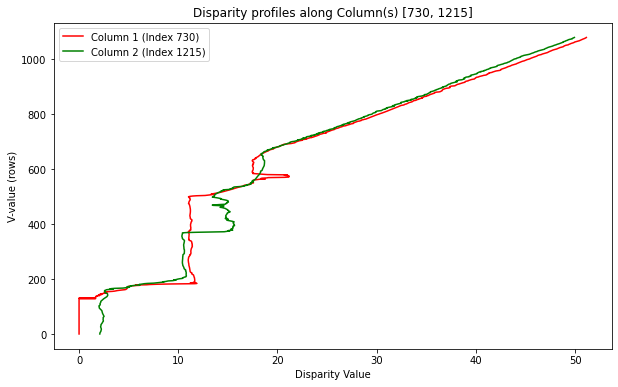

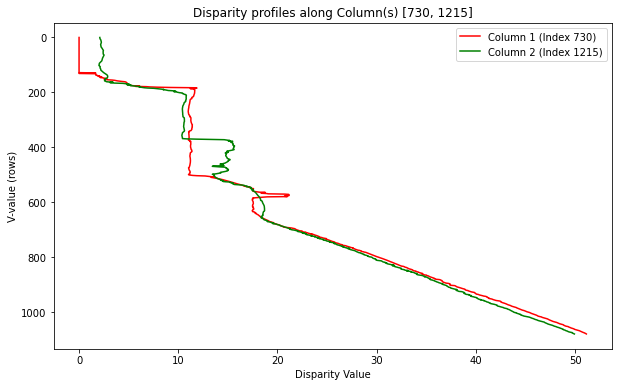

Første


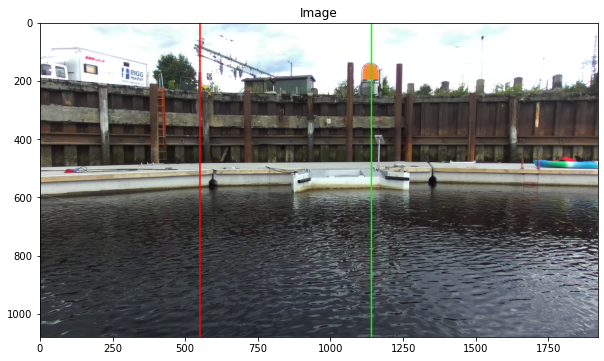

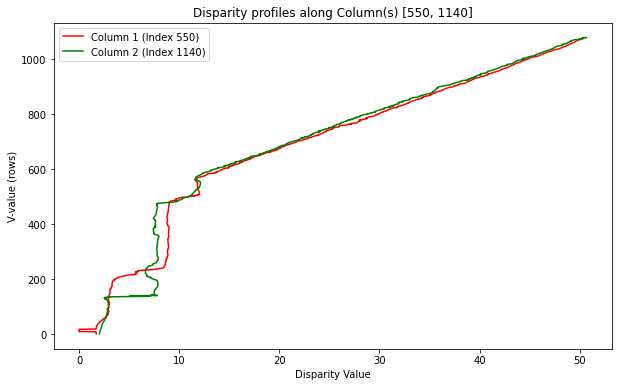

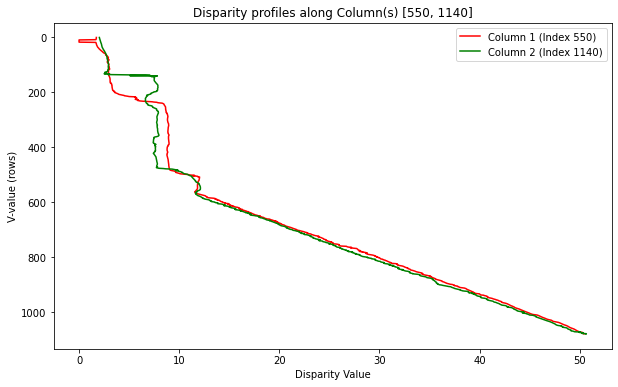

Badering


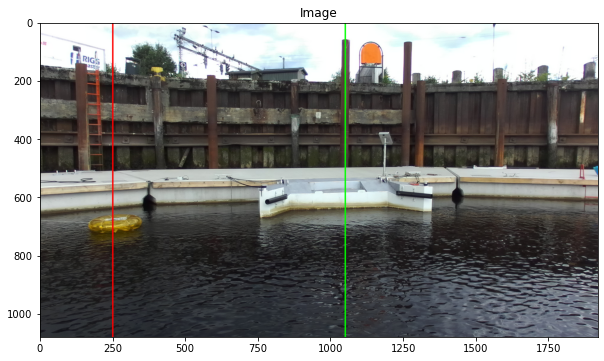

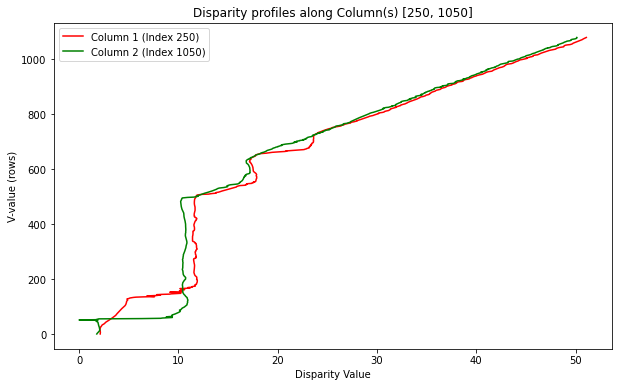

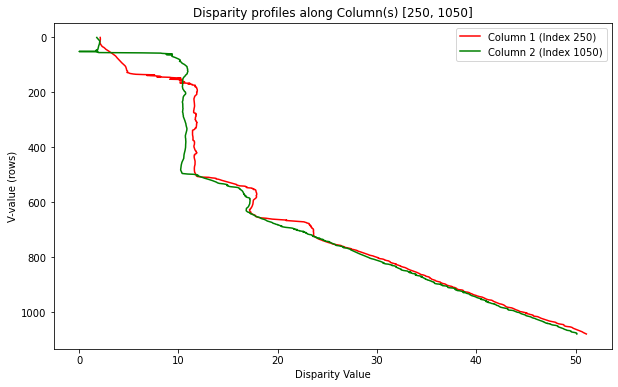

Mann


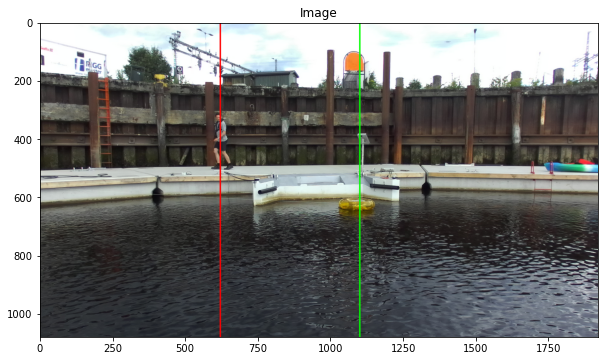

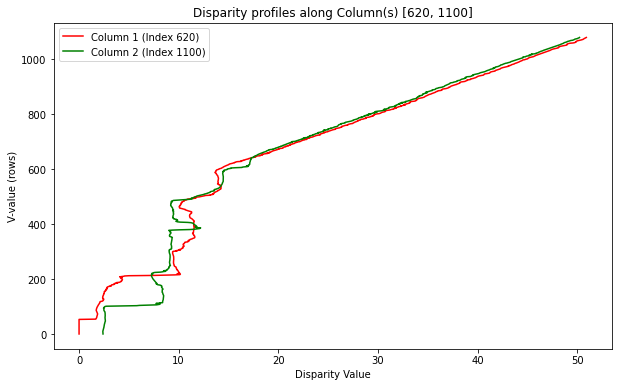

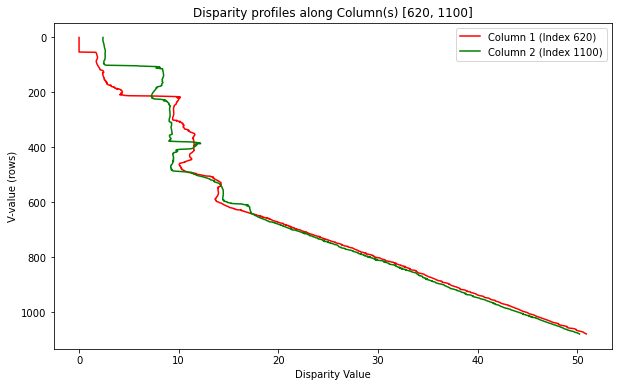

Båt


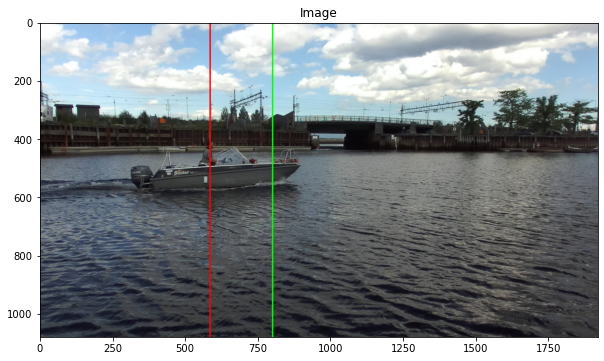

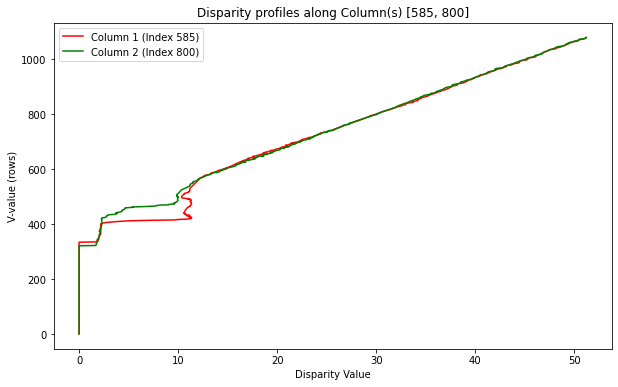

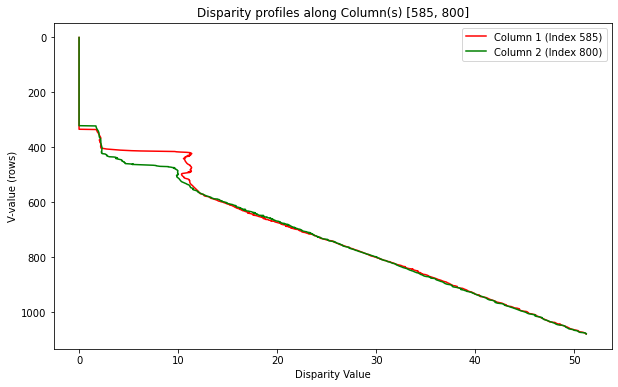

BåtKajakk


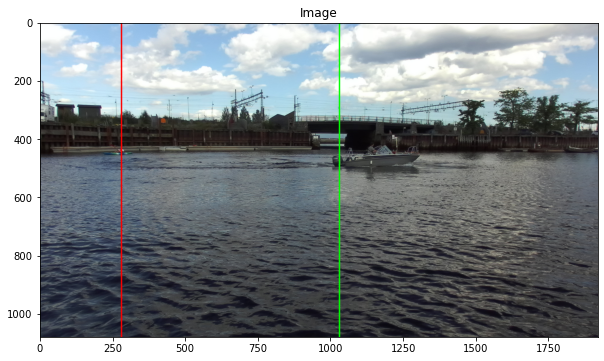

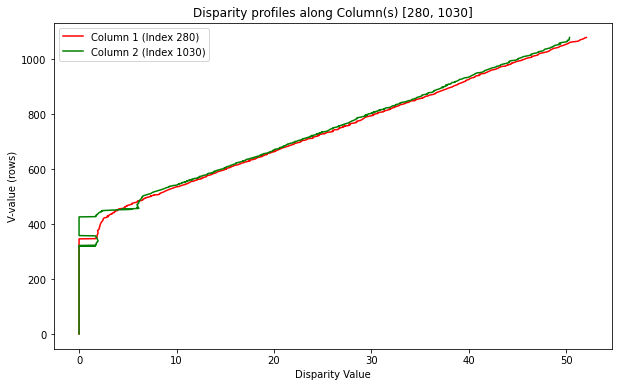

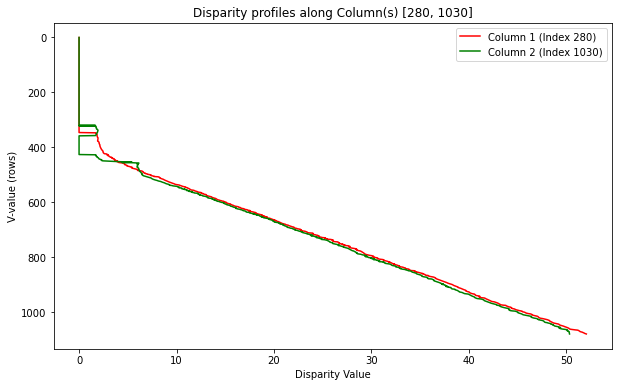

BåtBak


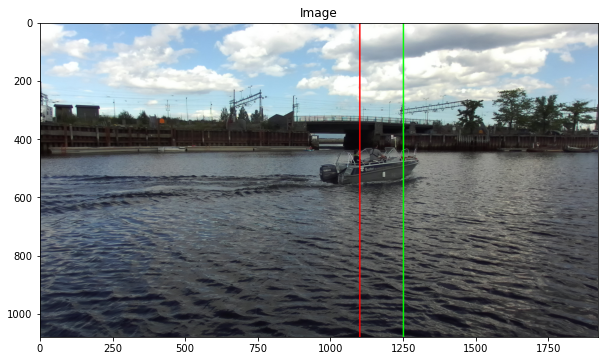

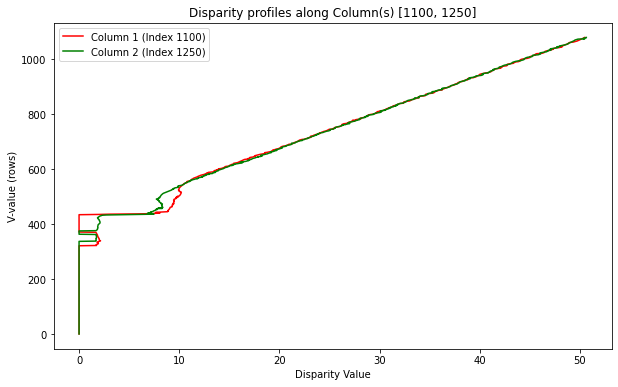

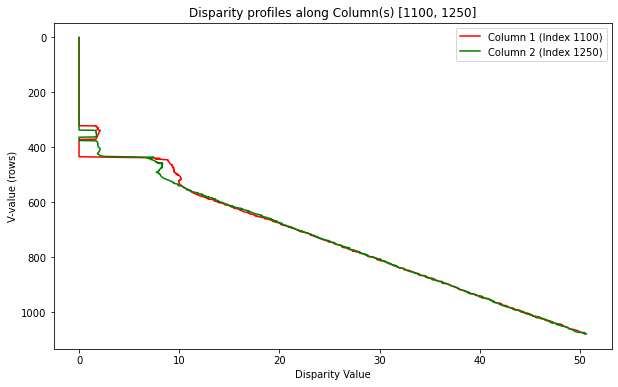

BåtFram


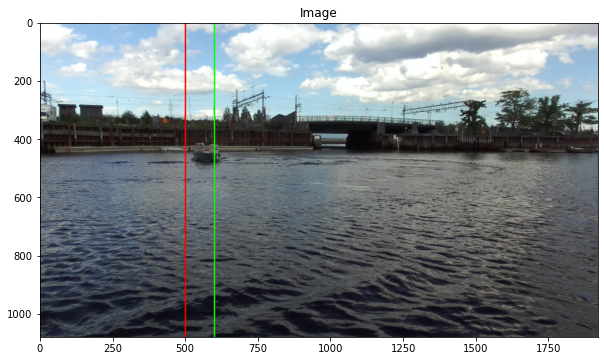

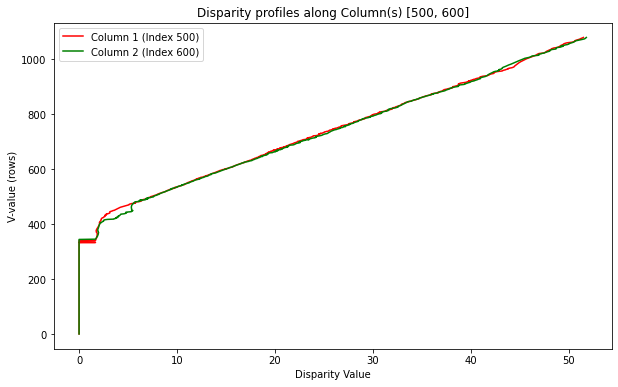

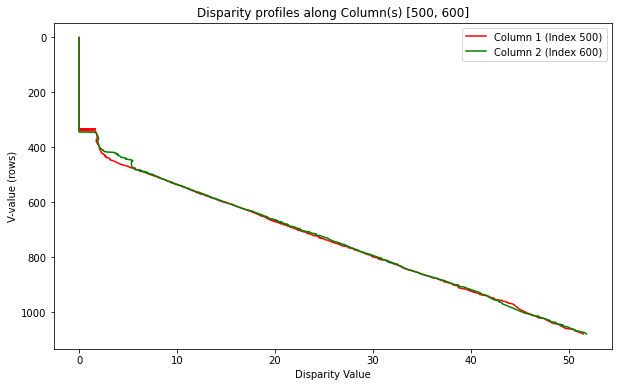

In [168]:
plot_initial_images = True


""" # Testing image
current_original_image = båt_fram_image
current_disparity_data = båt_fram_disparity
curr_col = [1250]
display_columns_on_image(current_original_image, curr_col)
disparity_graphing(current_disparity_data, curr_col, display=True, invert=True)
  """


if(plot_initial_images):

    
    # Nærme
    print("Nærme")
    #cols_nærme = [730, 1215, 1483]
    cols_nærme = [730, 1215]
    display_columns_on_image(nærme_image, cols_nærme)
    disparity_graphing(nærme_disparity, cols_nærme, display=True, invert=False)
    disparity_graphing(nærme_disparity, cols_nærme, display=True, invert=True)


    # Første
    print("Første")
    #cols_første = [550, 1140, 1810]
    cols_første = [550, 1140]
    display_columns_on_image(første_image, cols_første)
    disparity_graphing(første_disparity, cols_første, display=True, invert=False)
    disparity_graphing(første_disparity, cols_første, display=True, invert=True)


    # Badering
    print("Badering")
    #cols_badering = [250, 1050, 186]
    cols_badering = [250, 1050]
    display_columns_on_image(badering_første_image, cols_badering)
    disparity_graphing(badering_første_disparity, cols_badering, display=True, invert=False)
    disparity_graphing(badering_første_disparity, cols_badering, display=True, invert=True)

    # Mann
    print("Mann")
    #cols_mann = [620, 1100, 1880]
    cols_mann = [620, 1100]
    display_columns_on_image(badering_mann_image, cols_mann)
    disparity_graphing(badering_mann_disparity, cols_mann, display=True, invert=False)
    disparity_graphing(badering_mann_disparity, cols_mann, display=True, invert=True)

    # Båt
    print("Båt")
    #cols_båt = [340, 585, 800]
    cols_båt = [585, 800]
    display_columns_on_image(båt_image, cols_båt)
    disparity_graphing(båt_disparity, cols_båt, display=True, invert=False)
    disparity_graphing(båt_disparity, cols_båt, display=True, invert=True)

    # BåtKajakk
    print("BåtKajakk")
    #cols_båtKajakk = [280, 1030, 1250]
    cols_båtKajakk = [280, 1030]
    display_columns_on_image(kajakk_båt_image, cols_båtKajakk)
    disparity_graphing(kajakk_båt_disparity, cols_båtKajakk, display=True, invert=False)
    disparity_graphing(kajakk_båt_disparity, cols_båtKajakk, display=True, invert=True)
    
    
    # BåtBak
    print("BåtBak")
    #cols_båtBak = [1100, 1250, 1500]
    cols_båtBak = [1100, 1250]
    display_columns_on_image(båt_bak_image, cols_båtBak)
    disparity_graphing(båt_bak_disparity, cols_båtBak, display=True, invert=False)
    disparity_graphing(båt_bak_disparity, cols_båtBak, display=True, invert=True)

    # BåtFram
    print("BåtFram")
    #cols_båtFram = [500, 600, 1250]
    cols_båtFram = [500, 600]
    display_columns_on_image(båt_fram_image, cols_båtFram)
    disparity_graphing(båt_fram_disparity, cols_båtFram, display=True, invert=False)
    disparity_graphing(båt_fram_disparity, cols_båtFram, display=True, invert=True)
